# AMEX DEFAULT

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)

#Generic libraryies
import random
import math
import itertools

#Time and monitoring libraries
import time
from tqdm import tqdm
import pyprind

#Visual libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
labels = pd.read_csv("/kaggle/input/amex-default-prediction/train_labels.csv")

In [3]:
labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [4]:
labels.tail()

,customer_ID,target
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1
458912,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,0


In [5]:
labels.shape

(458913, 2)

In [6]:
#This is to take a rows divider and load data in chunks.
for n in range(10,int(math.sqrt(len(labels)))):
    if len(labels)%n == 0:
        print(n)
        break

13


In [7]:
loadN = int(len(labels)/n)
for i in tqdm(range(1,n+1)):
    if i != 1:
        skiprows = loadN*(i-1)
        train = df.append(pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv",  header = None, skiprows=skiprows , nrows=loadN, names=cols), ignore_index = True)
    else:
        df = pd.read_csv("/kaggle/input/amex-default-prediction/train_data.csv",nrows=loadN)
        cols = df.columns
df = df.drop_duplicates()
print("Load complete:", len(df) == len(labels) )

100%|██████████| 13/13 [01:15<00:00,  5.77s/it]


Load complete: False


In [8]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,NaN,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,NaN,0.652984,0.008520,NaN,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,NaN,0.007554,0.080422,0.069067,NaN,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,NaN,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,NaN,0.0,0.005720,0.007084,NaN,0.000198,0.008907,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,NaN,0.670041,0.009968,0.004572,NaN,1.008949,2.0,NaN,0.004326,NaN,NaN,NaN,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,NaN,0.002052,0.005972,NaN,0.004345,0.001535,NaN,NaN,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,NaN,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,CR,O,0.002413,0.007148,NaN,0.647093,0.002238,NaN,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,NaN,0.004832,0.081413,0.074166,NaN,0.004203,0.005304,NaN,0.001864,0.000979,0.009896,0.007597,0.000509,NaN,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,NaN,0.0,0.007584,0.006677,NaN,0.001142,0.005907,NaN,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,NaN,0.668647,0.003921,0.004654,NaN,1.003205,2.0,NaN,0.008707,NaN,NaN,NaN,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.707017,0.430501,0.001306,0.686414,0.000755,1.0,1.008394,1.004333,1.008344,0.004407,NaN,0.001034,0.004838,NaN,0.

In [9]:
df.tail()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
35296,01a67deb77803b597faa643ae3b086508f27a1df3d1cbc...,2018-03-30,0.930419,0.009918,0.021636,1.008958,0.001317,0.039549,0.003644,0.000088,NaN,NaN,0.007973,0.022078,0.351257,0.070159,0.006124,0.456313,0.445302,0.158081,NaN,0.199734,0.025470,0.002598,0.215533,0.342213,0.059973,0.004719,0.049980,0.523253,0.294814,NaN,0.023011,0.006413,0.006186,1.004031,0.009688,0.028717,0.065199,0.919935,0.107045,0.755508,0.065377,0.002908,0.004943,0.011389,0.028529,0.420302,0.536697,0.147048,0.006599,0.600074,0.107868,CO,O,0.009899,0.002553,NaN,1.009762,0.000631,NaN,0.000979,6.0,0.268145,0.006832,0.631066,0.007388,0.006169,0.004562,0.001952,0.010038,0.003996,0.109877,0.018560,NaN,0.002345,0.008544,0.006706,NaN,0.001557,0.002987,0.107377,0.041263,0.005238,0.000598,0.002006,0.003898,NaN,0.007918,0.005811,0.002195,0.008722,0.005590,0.000001,NaN,0.002137,1.000678,0.028777,0.002601,0.009407,0.006289,0.001946,0.004600,0.007102,NaN,0.0,0.009829,0.005229,NaN,0.007929,0.005811,NaN,1,0.004042,0.000913,0.007865,0.003041,0.008411,0.003436,1.003104,0.007238,0.006413,0.005438,0.008954,0.003636,0.006928,0.009802,0.009705,0.004887,0.007796,0.984163,0.136550,0.977995,0.971263,0.000574,0.005351,0.003944,0.001509,NaN,NaN,0.001217,0.002597,0.021820,NaN,1.008525,2.0,NaN,0.007042,NaN,NaN,NaN,1.008168,0.035873,0.465751,0.000145,1.0,0.499979,0.0,-1.0,0.468181,0.398550,0.0,0.556905,0.572394,0.004831,0.227612,0.001141,1.0,0.004959,1.000331,1.004323,0.006773,NaN,0.006305,0.009240,NaN,0.009109,0.009104,NaN,NaN,NaN,NaN,NaN,0.001524,0.008089,0.005381,NaN,0.009758,0.003901,0.007569
35297,01a691ea0b91a43c8179ffd6e52a3167fe20ec33964a96...,2017-03-03,0.713390,0.331206,0.010235,1.003066,0.506642,0.131010,0.009417,0.006028,NaN,0.267627,0.133137,0.070250,0.089626,0.093111,0.007253,0.586402,0.354271,1.161897,NaN,0.093467,0.054479,1.002928,0.171653,0.676089,0.038228,0.406585,0.096406,0.525009,0.064080,NaN,0.014817,0.006184,0.006243,1.005166,0.002785,0.102705,0.200153,0.668080,0.903871,0.412619,0.139151,0.005723,0.127303,0.008303,0.031552,0.405684,0.075083,1.191604,0.004897,0.407394,0.042965,CO,O,0.007452,0.001636,NaN,0.591466,0.006902,NaN,0.007997,6.0,0.193478,0.007689,0.421332,0.002097,0.007172,0.001545,0.251814,0.010342,0.008971,0.205999,0.050074,NaN,0.008240,0.077583,0.076450,NaN,0.005580,0.001762,NaN,0.051681,0.007996,0.509235,0.007908,0.002523,NaN,0.009959,0.005816,1.000153,0.005670,0.003628,0.004600,NaN,0.009326,1.001099,0.162487,0.006213,0.002773,0.001774,0.009666,0.005674,0.000124,NaN,0.0,0.006451,0.003227,NaN,0.005877,0.009064,NaN,1,0.002857,0.001153,0.007010,0.006237,0.001452,0.007473,1.008865,0.008853,0.007356,0.002188,0.003215,1.006909,0.000474,0.004163,0.004469,0.005092,0.005238,0.950064,0.131439,0.960752,0.972130,0.008385,0.526774,1.006064,0.969808,0.244231,NaN,0.335923,0.001416,0.006109,NaN,1.005871,2.0,NaN,0.008581,NaN,NaN,NaN,1.002970,0.116151,0.257209,0.000935,1.0,0.276628,0.0,4.0,0.272681,0.271931,0.0,0.607386,0.862690,0.004759,0.410491,0.000993,1.0,1.007158,1.003589,1.000143,0.004597,NaN,0.006083,0.001870,Na

# Target feature

First we will see the target's distribution.

In [10]:
labels.groupby("target").count()*100/len(labels)

,customer_ID
target,
0,74.106639
1,25.893361


Its 74% non-default vs 26% default. It isn't very unbalanced.

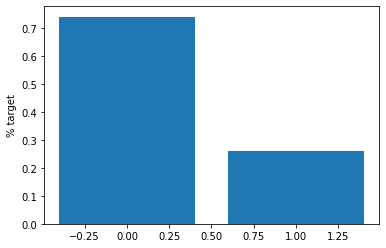

In [11]:
aux = labels.target.value_counts()/len(labels)
plt.bar(x = [0,1], height = [aux.iloc[0], aux.iloc[1]])
plt.ylabel('% target')
plt.show()

# Train EDA

First we are goint to analize numeric columns, because probably we must do aggregations and later these will be categorical.

**We must keep in mind that:**
* D_* = Delinquency variables
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables

In [12]:
dims = df.shape
print("We have", dims[0] , "rows and", dims[1], "columns.")

We have 35301 rows and 190 columns.


In [13]:
dropCols = []

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35301 entries, 0 to 35300
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 51.4+ MB


In [15]:
print(f"There are {df.select_dtypes('object').shape[1]} object columns \nThere are {df.select_dtypes('int').shape[1]} int columns\nThere are {df.select_dtypes('float').shape[1]} float columns")

There are 4 object columns 
There are 1 int columns
There are 185 float columns


In [16]:
categorical = []
integer = []
floats = []

for col in tqdm(df.columns):
    if df[col].dtype == 'O':
        categorical.append(col)
    elif df[col].dtype == 'float':
        floats.append(col)
    else:
        integer.append(col)

100%|██████████| 190/190 [00:00<00:00, 74159.48it/s]


### Drop columns duplicates

In [17]:
%time df = df.T.drop_duplicates().T

CPU times: user 11.4 s, sys: 628 ms, total: 12 s
Wall time: 11.9 s


In [18]:
for col in tqdm(df.columns):
    if col in integer:
        df[col] = pd.to_numeric(df[col])
    elif col in floats:
        df[col] = pd.to_numeric(df[col])

100%|██████████| 190/190 [00:09<00:00, 19.45it/s]


In [19]:
print(f"There are {df.select_dtypes('object').shape[1]} object columns \nThere are {df.select_dtypes('int').shape[1]} int columns\nThere are {df.select_dtypes('float').shape[1]} float columns")

There are 4 object columns 
There are 1 int columns
There are 185 float columns


### Integer columns

In [20]:
df.select_dtypes('int').nunique().sort_values().to_frame().T

,B_31
0,2


In [21]:
print(df["B_31"].unique())
print(df["B_31"].sum()*100/len(df) ,"are the same values, this column seem that hasn't got info.")

dropCols.append("B_31")

[1 0]
99.71388912495397 are the same values, this column seem that hasn't got info.


### Float columns

In [22]:
floatsAux = df.select_dtypes('float').nunique().sort_values().to_frame().T *100/len(df)
print("Columns with less than 5% distinct values, probably are not useless, we are going to analice and compare with other partitions. Then we will decide if this columns will be deleted.")

floatsAux = floatsAux[floatsAux <= 5 ].dropna(axis =1)
for col in floatsAux.columns.values:
    dropCols.append(col)
    
    
floatsAux

Columns with less than 5% distinct values, probably are not useless, we are going to analice and compare with other partitions. Then we will decide if this columns will be deleted.


,D_87,D_120,D_66,D_116,D_114,D_126,B_30,D_117,B_38,D_68,D_88,D_110,D_111,B_39,D_108,D_73,B_42,D_134,D_135,D_138,D_137,D_136
0,0.002833,0.005666,0.005666,0.005666,0.005666,0.008498,0.008498,0.019829,0.019829,0.019829,0.127475,0.509901,0.509901,0.532563,0.572222,1.025467,1.410725,3.764766,3.764766,3.764766,3.764766,3.764766


### Categorical columns

In [23]:
df.select_dtypes('O').nunique().sort_values().to_frame().T

,D_64,D_63,S_2,customer_ID
0,4,6,396,2925


In [24]:
df.groupby("D_64").count()["customer_ID"]*100/len(df)

D_64
-1     0.708195
O     54.454548
R     13.838135
U     27.327838
Name: customer_ID, dtype: float64

In [25]:
df.groupby("D_63").count()["customer_ID"]*100/len(df)

D_63
CL     8.098921
CO    75.247160
CR    15.880570
XL     0.167134
XM     0.127475
XZ     0.478740
Name: customer_ID, dtype: float64

In [26]:
train = df.merge(labels, on = ["customer_ID"], how = "left")

### ¿Drop columns?

In [27]:
train[dropCols]

,B_31,D_87,D_120,D_66,D_116,D_114,D_126,B_30,D_117,B_38,D_68,D_88,D_110,D_111,B_39,D_108,D_73,B_42,D_134,D_135,D_138,D_137,D_136
0,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35296,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,-1.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35297,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35298,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35299,1,NaN,0.0,NaN,0.0,1.0,1.0,0.0,4.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### B_31

In [28]:
df["B_31"].value_counts()

1    35200
0      101
Name: B_31, dtype: int64

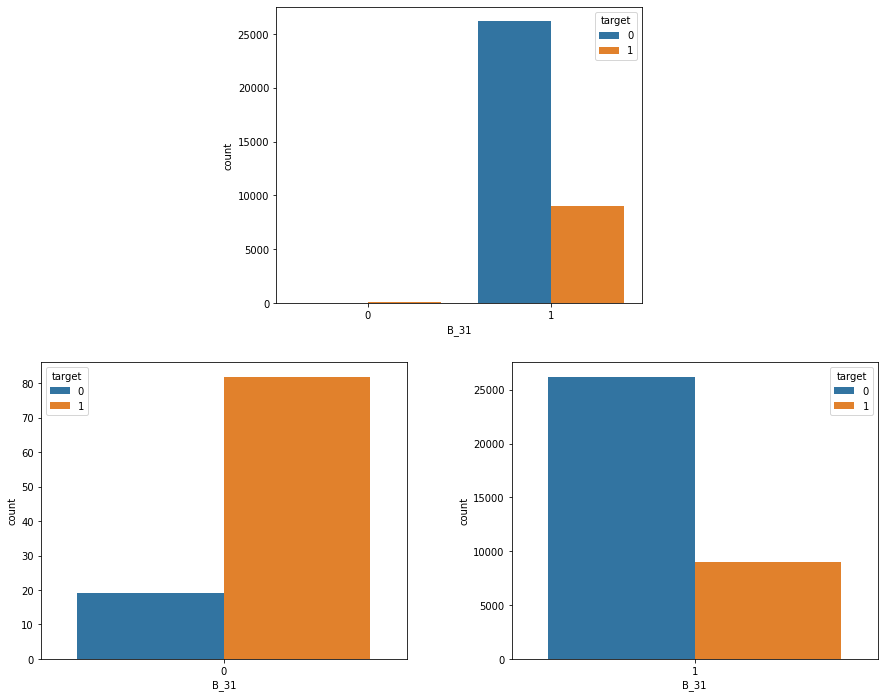

In [29]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(2, 4, figure = fig)
gs.update(wspace=0.8 )

ax1 = plt.subplot(gs[1, :2], )
sns.countplot(data = train[train["B_31"] == 0][[dropCols[0], "target"]] , x = "B_31", hue = "target", ax=ax1)

ax2 = plt.subplot(gs[1, 2:])
sns.countplot(data = train[train["B_31"] == 1][[dropCols[0], "target"]] , x = "B_31", hue = "target" , ax=ax2)

ax3 = plt.subplot(gs[0, 1:3])
sns.countplot(data = train[[dropCols[0], "target"]] , x = "B_31", hue = "target", ax=ax3)

plt.show()